In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', None)

In [2]:
events_path = "https://beam-outputs.s3.amazonaws.com/output/beamville/beamville__2022-12-27_16-04-11_czt/ITERS/it.0/0.events.csv"
# !wget "$events_path"
# !ls

events_all = pd.read_csv(events_path, low_memory=False)
# print(events_all['type'].unique())

### filtering only refuel session events,
### using only columns with useful data

events_charging = events_all[events_all['type'] == 'RefuelSessionEvent'].copy()
events_charging['hour'] = events_charging['time'] // 3600

# for column in events_charging.columns:
#     print(column, events_charging[column].unique())

selected_columns = ['hour','chargingPointType','price','fuel','duration']
events_charging = events_charging[selected_columns].copy()

print(events_charging.shape)
display(events_charging.head(3))

(8, 5)


,hour,chargingPointType,price,fuel,duration
3638,7.0,dcfast(50.0|DC),0.0,0.0,0.0
3640,7.0,dcfast(50.0|DC),0.0,0.0,0.0
3642,7.0,dcfast(50.0|DC),0.0,0.0,0.0


In [3]:
### preparing the dataframe with charging events to be plot as area
### i.e. for each pair (hour, charging point type) all values should be in DataFrame (or 0 if no values)

events = events_charging.groupby(['hour','chargingPointType']).agg(list)

all_charging_point_types = list(events.index.unique('chargingPointType'))

#
# adding rows of zeros for all missing index (hour, charging point type) keys
#
missing_index = []
for an_hour in list(events.index.unique('hour')):
    for a_charging_point_type in all_charging_point_types:
        an_index_key = (an_hour, a_charging_point_type)
        if an_index_key not in events.index:
            missing_index.append(an_index_key)

current_index = list(events.index.values)
events = events.reindex(current_index + missing_index).sort_index().reset_index()


#
# reformatting DataFrame
#

def sum_or_zero(maybe_list):
    if isinstance(maybe_list, list):
        return float(sum(maybe_list))
    return 0.0

def len_or_zero(maybe_list):
    if isinstance(maybe_list, list):
        return len(maybe_list)
    return 0

dfs = []
for a_charging_point_type in all_charging_point_types:
    df = events[events['chargingPointType'] == a_charging_point_type].set_index('hour')[['price','fuel','duration']]
    df['count'] = df.apply(lambda x: len_or_zero(x['price']), axis=1)
    df['price'] = df.apply(lambda x: sum_or_zero(x['price']), axis=1)
    df['fuel'] = df.apply(lambda x: sum_or_zero(x['fuel']), axis=1)
    df['duration'] = df.apply(lambda x: sum_or_zero(x['duration']), axis=1)

    df.columns = map(lambda col_name: f"{a_charging_point_type}_{col_name}", df.columns)
    dfs.append(df)
    
df_merged = dfs[0]
for df in dfs[1:]:
    df_merged = df_merged.join(df)
    
print(f"there are {len(df_merged)} rows in resulting DataFrame")
display(df_merged.head(2))

there are 2 rows in resulting DataFrame


,dcfast(50.0|DC)_price,dcfast(50.0|DC)_fuel,dcfast(50.0|DC)_duration,dcfast(50.0|DC)_count,level1(2.3|AC)_price,level1(2.3|AC)_fuel,level1(2.3|AC)_duration,level1(2.3|AC)_count
hour,,,,,,,,
7.0,0.0,0.0,0.0,3,0.0,2309200.0,1004.0,1
20.0,0.0,0.0,0.0,3,0.0,2996900.0,1303.0,1


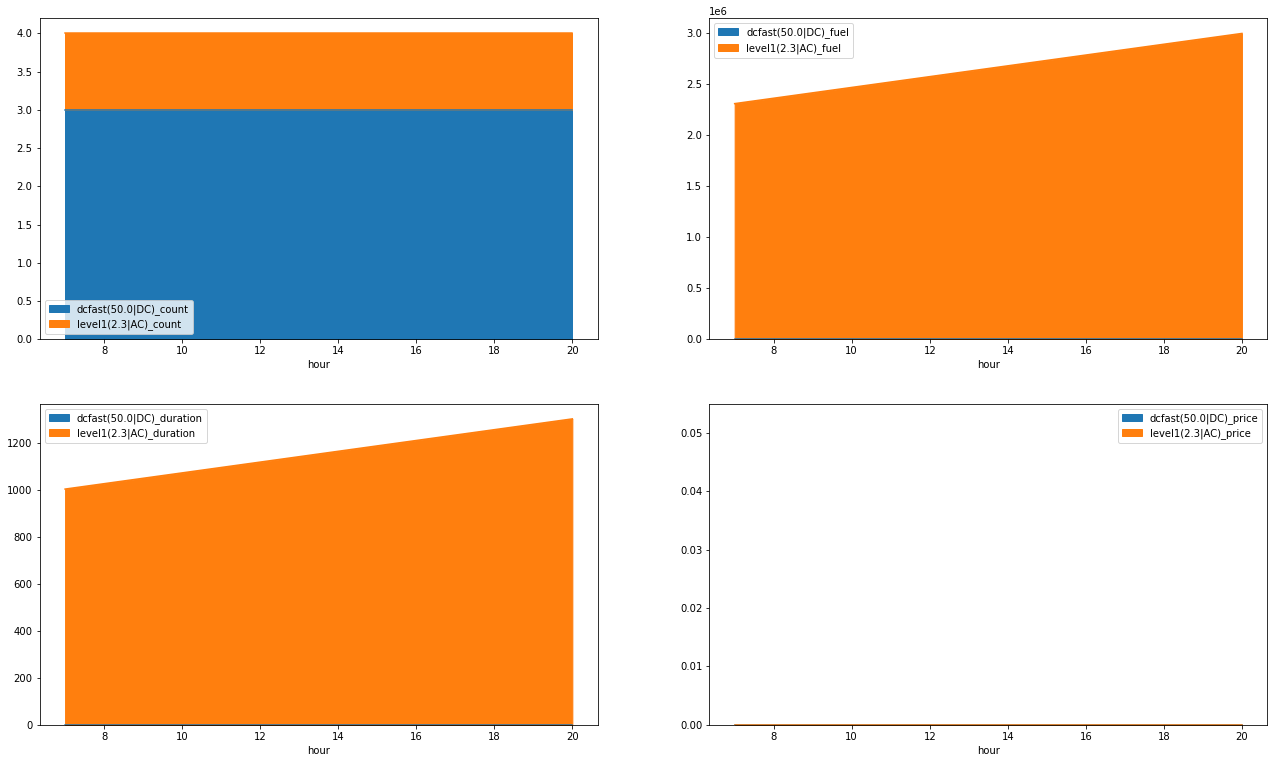

In [4]:
### plotting for count, fuel, duration and price

df = df_merged[df_merged.index < 30]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(22,13))

for (figtype, axis) in zip(['count','fuel', 'duration', 'price'], [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]):
    df[[col for col in df.columns if figtype in col]].plot.area(ax=axis)


,sales,signups,visits
2018-01-31,3,5,20
2018-02-28,2,5,42
2018-03-31,3,6,28
2018-04-30,9,12,62
2018-05-31,10,14,81
2018-06-30,6,13,50


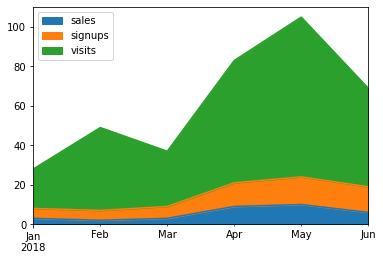

In [5]:
### an example of an area plot

df = pd.DataFrame({
    'sales': [3, 2, 3, 9, 10, 6],
    'signups': [5, 5, 6, 12, 14, 13],
    'visits': [20, 42, 28, 62, 81, 50],
}, index=pd.date_range(start='2018/01/01', end='2018/07/01', freq='M'))

display(df)
ax = df.plot.area()